In [16]:
import os
import json
import yaml
import time
from redis import Redis
from rq import Queue, Retry
from rq.job import Job
import traceback
import sys

import warnings
import matplotlib.cbook
from joyflo import reactflow_to_networkx

In [17]:
from FUNCTIONS.GENERATORS import *
from FUNCTIONS.TRANSFORMERS import *
from FUNCTIONS.VISORS import *

In [18]:
stream = open('STATUS_CODES.yml', 'r',encoding="utf8")
STATUS_CODES = yaml.safe_load(stream)

from utils import PlotlyJSONEncoder

import os

REDIS_HOST = os.environ.get('REDIS_HOST', 'localhost')
REDIS_PORT = os.environ.get('REDIS_PORT', 6379)

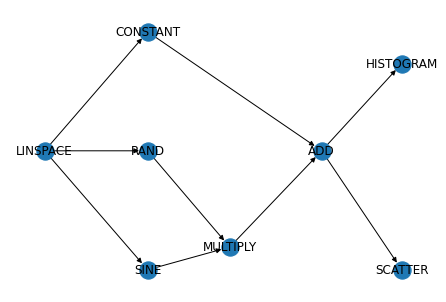

In [19]:
r = Redis(host=REDIS_HOST, port=REDIS_PORT)
q = Queue('flojoy', connection=r)


# Load React flow chart object from JSON file

f = open('./fc.json')
fc = json.loads(f.read())
elems = fc['elements']

# Replicate the React Flow chart in Python's networkx

convert_reactflow_to_networkx = reactflow_to_networkx(elems)

# get topological sorting from reactflow_to_networx function imported from flojoy package

topological_sorting = convert_reactflow_to_networkx['topological_sort']

nodes_by_id = convert_reactflow_to_networkx['getNode']()
DG = convert_reactflow_to_networkx['DG']

def report_failure(job, connection, type, value, traceback):
    print(job, connection, type, value, traceback)

def jid(n):
    return 'JOB_ID_{0}'.format(n)

In [20]:
for n in topological_sorting:
    cmd = nodes_by_id[n]['cmd']
    ctrls = nodes_by_id[n]['ctrls']
    print('*********************')
    print('node:', n, 'ctrls:', ctrls, "cmd: ", cmd,)
    print('*********************')
    # print('globals:', globals())

    func = getattr(globals()[cmd], cmd)
    print('func:', func)
    job_id = jid(n)

    s = ' '.join([STATUS_CODES['JOB_IN_RQ'], cmd.upper()])
    r.set('SYSTEM_STATUS', s)

    if len(list(DG.predecessors(n))) == 0:
        print('{0} ({1}) has no predecessors'.format(cmd, n))
        q.enqueue(func,
            retry=Retry(max=100), # TODO: have to understand why the SINE node is failing for few times then succeeds
            job_timeout='3m',
            on_failure=report_failure,
            job_id = job_id,
            kwargs={'ctrls': ctrls},
            result_ttl=500)
        print('ENQUEUING...', cmd, job_id, ctrls)
    else:
        previous_job_ids = []
        for p in DG.predecessors(n):
            prev_cmd = DG.nodes[p]['cmd']
            prev_job_id = jid(p)
            previous_job_ids.append(prev_job_id)
            print(prev_cmd, 'is a predecessor to', cmd)
        q.enqueue(func,
            retry=Retry(max=100),
            job_timeout='3m',
            on_failure=report_failure,
            job_id=job_id,
            kwargs={'ctrls': ctrls,'previous_job_ids':previous_job_ids,},
            depends_on=previous_job_ids,
            result_ttl=500)
        print('ENQUEUING...', cmd, job_id, ctrls, previous_job_ids)

*********************
node: 7 ctrls: {} cmd:  LINSPACE
*********************
func: <function flojoy.<locals>.inner at 0x000001EDD4024D30>
LINSPACE (7) has no predecessors
ENQUEUING... LINSPACE JOB_ID_7 {}
*********************
node: 1 ctrls: {} cmd:  SINE
*********************
func: <function flojoy.<locals>.inner at 0x000001EDCBF3A8C0>
LINSPACE is a predecessor to SINE
ENQUEUING... SINE JOB_ID_1 {} ['JOB_ID_7']
*********************
node: 3 ctrls: {} cmd:  RAND
*********************
func: <function flojoy.<locals>.inner at 0x000001EDD40249D0>
LINSPACE is a predecessor to RAND
ENQUEUING... RAND JOB_ID_3 {} ['JOB_ID_7']
*********************
node: 8 ctrls: {} cmd:  CONSTANT
*********************
func: <function flojoy.<locals>.inner at 0x000001EDD4024C10>
LINSPACE is a predecessor to CONSTANT
ENQUEUING... CONSTANT JOB_ID_8 {} ['JOB_ID_7']
*********************
node: 2 ctrls: {} cmd:  MULTIPLY
*********************
func: <function flojoy.<locals>.inner at 0x000001EDD4025090>
SINE is a pr




Getting Node Outputs
Job status: LINSPACE failed origin: flojoy attempt: 1
Job status: SINE deferred origin: flojoy attempt: 1
canceling SINE due to failure in another node
Job status: RAND deferred origin: flojoy attempt: 1
canceling RAND due to failure in another node
Job status: CONSTANT deferred origin: flojoy attempt: 1
canceling CONSTANT due to failure in another node
Job status: MULTIPLY deferred origin: flojoy attempt: 1
canceling MULTIPLY due to failure in another node
Job status: ADD deferred origin: flojoy attempt: 1
canceling ADD due to failure in another node
Job status: SCATTER deferred origin: flojoy attempt: 1
canceling SCATTER due to failure in another node
Job status: HISTOGRAM deferred origin: flojoy attempt: 1
canceling HISTOGRAM due to failure in another node


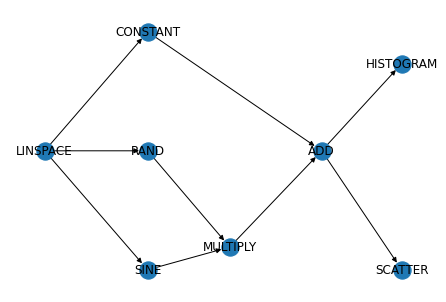

In [21]:
all_node_results = []
topological_sorting = reactflow_to_networkx(elems)['topological_sort']

print('\n\n')
print("Getting Node Outputs")

is_any_node_failed = False
for n in topological_sorting:
    job_id = jid(n)
    nd = nodes_by_id[n]
    # TODO have to investigate if and why this fails sometime
    # best is to remove this try catch, so we will have to come back to it soon
    try:
        job = Job.fetch(job_id, connection=r)
    except Exception:
        print(traceback.format_exc())
    job_status, redis_payload, attempt_count = None, None, 0
    while True: # or change it to wait for maximum amount of time, then we can declare job timed out
        time.sleep(0.5)
        job_status= job.get_status(refresh=True)
        redis_payload = job.result
        attempt_count += 1

        print('Job status:', nd['cmd'], job_status, 'origin:', job.origin, 'attempt:', attempt_count)
        if attempt_count > 9:
            job.delete()
            break
        if job_status == 'finished':
            break
        if is_any_node_failed:
            print('canceling', nd['cmd'], 'due to failure in another node')
            job.delete()
            job_status = "cancelled"
            break
        if job_status == 'failed':
            is_any_node_failed = True
            break
        if job_status == 'deferred':
            registry = q.deferred_job_registry
            registry.requeue(job_id)

    all_node_results.append({'cmd': nd['cmd'], 'id': nd['id'], 'result':redis_payload, 'job_status': job_status})